In [1]:
pip install pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load trader data
trader_df = pd.read_csv("historical_data.csv")

# Load fear-greed sentiment data
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [5]:
print(trader_df.head())
print(trader_df.info())

print(sentiment_df.head())
print(sentiment_df.info())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [7]:
print(trader_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [17]:
print(sentiment_df.columns.tolist())

['timestamp', 'value', 'classification', 'date']


# Timestamp IST format is: DD-MM-YYYY HH:MM
# Example: 18-03-2025 12:50

In [ ]:
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'            # invalid timestamps become NaT
)

In [53]:
# Drop rows where timestamp failed to parse
trader_df = trader_df.dropna(subset=['Timestamp IST'])

# Extract date string
trader_df['date_str'] = trader_df['Timestamp IST'].dt.strftime('%Y-%m-%d')

In [ ]:
numeric_cols = ['Closed PnL', 'Size USD', 'Execution Price', 'Fee']
for col in numeric_cols:
    trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

# Remove trades where PnL is missing
trader_df = trader_df.dropna(subset=['Closed PnL'])

In [ ]:
# Convert sentiment date column to same YYYY-MM-DD format
sentiment_df['date_str'] = pd.to_datetime(
    sentiment_df['date'],
    errors='coerce'
).dt.strftime('%Y-%m-%d')


In [ ]:
# Drop rows with invalid dates
sentiment_df = sentiment_df.dropna(subset=['date_str'])

In [ ]:
# Clean sentiment labels (fear / greed → Fear / Greed)
sentiment_df['classification'] = (
    sentiment_df['classification']
    .astype(str)
    .str.strip()
    .str.capitalize()
)

In [ ]:
# Merge on normalized date string
merged_df = trader_df.merge(
    sentiment_df,
    on='date_str',
    how='inner'
)

In [ ]:
# Sanity check: merged data should NOT be empty
print("Merged shape:", merged_df.shape)
print(merged_df[['date_str', 'classification', 'Closed PnL']].head())

Merged shape: (211218, 22)
     date_str classification  Closed PnL
0  2024-12-02  Extreme greed         0.0
1  2024-12-02  Extreme greed         0.0
2  2024-12-02  Extreme greed         0.0
3  2024-12-02  Extreme greed         0.0
4  2024-12-02  Extreme greed         0.0


In [ ]:
# Create Win/Loss indicator
merged_df['Win'] = merged_df['Closed PnL'] > 0

In [ ]:
# Average profit/loss by market sentiment
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()
print("\nAverage PnL by Market Sentiment:\n", avg_pnl)


Average PnL by Market Sentiment:
 classification
Extreme fear     34.537862
Extreme greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


In [ ]:
# Win rate (%) by sentiment
win_rate = merged_df.groupby('classification')['Win'].mean() * 100
print("\nWin Rate (%) by Market Sentiment:\n", win_rate)


Win Rate (%) by Market Sentiment:
 classification
Extreme fear     37.060748
Extreme greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: Win, dtype: float64


In [ ]:
# Number of trades under each sentiment
trade_count = merged_df['classification'].value_counts()
print("\nTrade Count by Market Sentiment:\n", trade_count)


Trade Count by Market Sentiment:
 classification
Fear             61837
Greed            50303
Extreme greed    39992
Neutral          37686
Extreme fear     21400
Name: count, dtype: int64


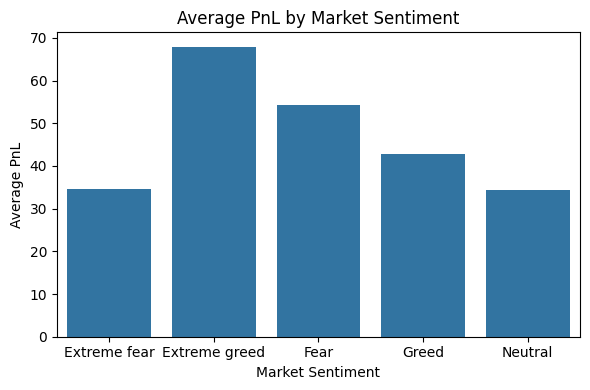

In [ ]:
# Average PnL bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=avg_pnl.index, y=avg_pnl.values)
plt.title("Average PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.show()

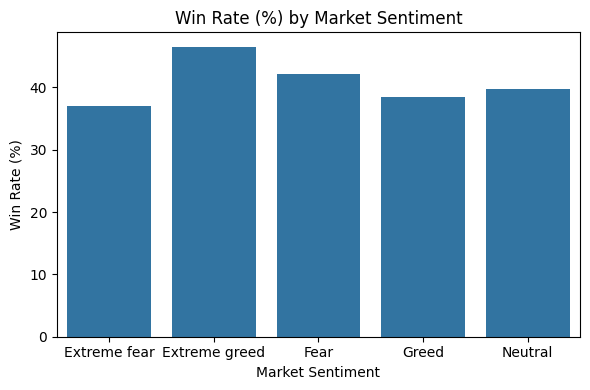

In [ ]:
# Win rate bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=win_rate.index, y=win_rate.values)
plt.title("Win Rate (%) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.tight_layout()
plt.show()

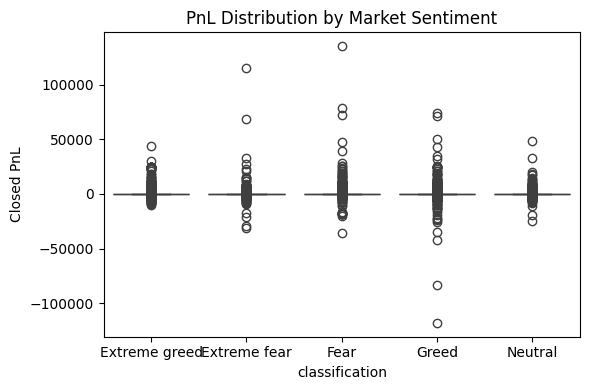

In [ ]:
# PnL distribution boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title("PnL Distribution by Market Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
# Identify top 10 traders by total PnL
top_traders = (
    merged_df.groupby('Account')['Closed PnL']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

In [69]:
print("\nTop 10 Traders by Total PnL:\n", top_traders)


Top 10 Traders by Total PnL:
 Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    2.143383e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401638e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    8.404226e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    8.360806e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.777471e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd    4.293556e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    4.165419e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.790954e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    3.605395e+05
Name: Closed PnL, dtype: float64


Save merged dataset

In [ ]:
# Useful for further analysis or sharing 
# merged_df.to_csv("merged_trader_sentiment_data.csv", index=False)